# Exploring Shastry-Sutherland model with symmetric RBM (similar machine as in Science 2017)

In [1]:
import netket as nk
import numpy as np
import time
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import jax
import flax
import pprint
print("NetKet version: {}".format(nk.__version__))
print("NumPy version: {}".format(np.__version__))

NetKet version: 3.3
NumPy version: 1.20.3


Setup relevant parameters

In [2]:
"""lattice"""
SITES    = 100            # 4, 8, 16, 20 ... number of vertices in a tile determines the tile shape 
JEXCH1   = .9            # nn interaction
JEXCH2   = 1            # nnn interaction
#USE_MSR  = True        # should we use a Marshall sign rule?
"""machine learning"""
TOTAL_SZ = None         # 0, None ... restriction of Hilbert space
DTYPE = np.complex128   # type of weights in neural network
SAMPLER = 'local'       # 'local' = MetropolisLocal, 'exchange' = MetropolisExchange
ALPHA = 16              # N_hidden / N_visible
ETA   = .01             # learning rate (0.01 usually works)
SAMPLES = 1200
NUM_ITER = 500

OUT_NAME = "SS-RBM_ops"+str(SITES)+"j1="+str(JEXCH1) # output file name

Lattice and hamiltonian definition: &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $ H = J_{1} \sum\limits_{\langle i,j \rangle}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{j} + J_{2} \sum\limits_{\langle\langle i,j \rangle\rangle_{SS}}^{L}  \vec{\sigma}_{i} \cdot \vec{\sigma}_{j}\,, $

In [3]:
from lattice_and_ops import Lattice
lattice = Lattice(SITES)

# Define custom graph
edge_colors = []
for node in range(SITES):
    edge_colors.append([node,lattice.rt(node), 1]) #horizontal connections
    edge_colors.append([node,lattice.bot(node), 1]) #vertical connections
    row, column = lattice.position(node)
    if column%2 == 0:
        if row%2 == 0:
            edge_colors.append([node,lattice.lrt(node),2])
        else:
            edge_colors.append([node,lattice.llft(node),2])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors) #,n_nodes=3)

hilbert = nk.hilbert.Spin(s=.5, N=g.n_nodes, total_sz=TOTAL_SZ)


#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz)) #=sz*sz
#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]) #=sx*sx+sy*sy = 1/2*(sp*sm+sm*sp)
full_spin = mszsz+exchange # = S*S = sx*sx + sy*sy + sz*sz
bond_color = [1, 2, 1, 2]

In [4]:
g.edges(filter_color=2)

[(0, 11),
 (2, 13),
 (4, 15),
 (6, 17),
 (8, 19),
 (10, 29),
 (12, 21),
 (14, 23),
 (16, 25),
 (18, 27),
 (20, 31),
 (22, 33),
 (24, 35),
 (26, 37),
 (28, 39),
 (30, 49),
 (32, 41),
 (34, 43),
 (36, 45),
 (38, 47),
 (40, 51),
 (42, 53),
 (44, 55),
 (46, 57),
 (48, 59),
 (50, 69),
 (52, 61),
 (54, 63),
 (56, 65),
 (58, 67),
 (60, 71),
 (62, 73),
 (64, 75),
 (66, 77),
 (68, 79),
 (70, 89),
 (72, 81),
 (74, 83),
 (76, 85),
 (78, 87),
 (80, 91),
 (82, 93),
 (84, 95),
 (86, 97),
 (88, 99),
 (9, 90),
 (1, 92),
 (3, 94),
 (5, 96),
 (7, 98)]

In [5]:
len(g.automorphisms())

200

In [6]:
print("There are", len(g.automorphisms()), "full symmetries:")
JEXCH1 = 0.1
if JEXCH1 < 0.5:
    characters = []
    from lattice_and_ops import permutation_sign
    for perm in g.automorphisms():
        # print(perm, permutation_sign(np.asarray(perm)))
        characters.append(permutation_sign(np.asarray(perm)))
    characters_dimer = np.asarray(characters,dtype=complex) #np.array([1,-1,1,-1,-1,1,-1,1], dtype=complex) # 2*2 SS model
    characters_dimer_msr = characters_dimer
else:
    characters_dimer = np.ones((len(g.automorphisms()),), dtype=complex)
    characters_dimer_msr = characters_dimer
print(characters_dimer)
print(characters_dimer_msr)
# print("There are", len(translation_group),"restricted symmetries:")
# print(translation_group)

There are 200 full symmetries:
[ 1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j
 -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j
  1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j
  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j
 -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j
 -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j
  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j
 -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j
 -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j
  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j
 -1.+0.j -1.+0.j  1.

In [100]:
translations = []
for perm in g.automorphisms():
    aperm = np.asarray(perm)
    # if (aperm[0],aperm[1]) in ((0,1),(1,0),(2,3),(3,2)):
    if (aperm[0],aperm[1],aperm[3]) in ((0,1,3),):#(2,3,1),(8,9,11),(10,11,9)): # N = 16
    # if (aperm[0],aperm[1],aperm[2],aperm[3]) in ((4,7,6,5),): # N = 8
        translations.append(nk.utils.group._permutation_group.Permutation(aperm))
# print(translations)
translation_group = nk.utils.group._permutation_group.PermutationGroup(translations,degree=SITES)
print(translation_group)
print(len(g.automorphisms()))
for perm in g.automorphisms():
    print(perm)

KeyboardInterrupt: 

## Hamoltonian

In [87]:
from lattice_and_ops import HamOps
ho = HamOps()
ha = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, use_MSR=False), bond_ops_colors=ho.bond_color)
ha_MSR = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, use_MSR=True), bond_ops_colors=ho.bond_color)


## Exact diagonalization

In [88]:
if g.n_nodes < 21:
    start = time.time()
    evals, eigvects = nk.exact.lanczos_ed(ha, k=3, compute_eigenvectors=True)
    #evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False) #.lanczos_ed
    end = time.time()
    diag_time = end - start
    exact_ground_energy = evals[0]
    print("Ground state energy:",exact_ground_energy, "\nIt took ", round(diag_time,2), "s =", round((diag_time)/60,2),"min")
else:
    print("System is too large for exact diagonalization. Setting exact_ground_energy = 0 (which is wrong)")
    exact_ground_energy = [0,0,0]
    eigvects = None 
# -36.2460684609957 

Ground state energy: -12.399999999999995 
It took  0.0 s = 0.0 min


## RBM

!!POZOZ je použito `g.automorphisms()` namísto `g.translations()` - obsahuje to tedy symetrii zrcadlení řetízku navíc, a proto na konci dostaneme jen dvě sady filtrů namísto čtyřech.

Vskutku, metoga g.automorphisms() najde veškeré symetrie. V tomto případě jsou všechny složeny z nezávislých symetrií:
<!-- ### Heisenberg
 * zrcadlení okolo $x$, 
 * zdcadlení okolo $y$, 
 * jedna rotace o $90$ stupňů (ostatní se dají složit se zrcadleními),
 * ``L_NUM*L_NUM`` translací,

tedy celkem $8L_{NUM}^2$ (pro $L_{NUM} > 2$, protože pro $L_{NUM}=2$ je zrcadlení a translace ekvivalentní) -->

### Shastry-Sutherland 
 * $\frac{L_{NUM}}{2} \cdot \frac{L_{NUM}}{2}$ translací,
 * rotace o $90$ stupňů (4x),

tedy celkem alespoň $L_{NUM}^2 = N$ (stejně je vždy $L_{NUM} \geq 4$) symetrií

```
#comment from github: Have you tried using g.translation_group() (or g.translations() is some of the previous beta versions)
 instead of .automorphisms() to check whether that makes a difference? (Using the larger group of all 6x6 space group symmetries 
 is probably also the reason why a large alpha is required in your version.) While symmetries should make a state easier to learn,
 I do recall that using the full space or automorphism group (instead of the usually easier-to-handle translation group) can 
 sometimes introduce convergence issues (which at least need some more careful tuning of optimization settings and probably 
 initial params to overcome).
#https://github.com/netket/netket/discussions/838
```

In [74]:
#definice modelu, sampleru atd.

# Symmetric RBM Spin Machine
machine = nk.models.RBMSymm(g.automorphisms(),dtype=DTYPE, alpha=ALPHA)#, use_visible_bias=False) 
# machine = nk.models.RBMSymm(translation_group, dtype=DTYPE, alpha=ALPHA, use_visible_bias=False)
print("Number of automorphisms:", len(g.automorphisms()))
# Symmetric RBM Spin Machine with MSR
# machine_MSR = nk.models.RBM(dtype=DTYPE, alpha=ALPHA)#, use_visible_bias=False)
machine_MSR = nk.models.RBMSymm(g.automorphisms(), dtype=DTYPE, alpha=ALPHA)#, use_visible_bias=False)


# Meropolis Exchange Sampling
if SAMPLER == 'local':
    sampler = nk.sampler.MetropolisLocal(hilbert=hilbert)
    sampler_MSR = nk.sampler.MetropolisLocal(hilbert=hilbert)
else:
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    sampler_MSR = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    if SAMPLER != 'exchange':
        print("Warning! Undefined sampler:", SAMPLER, ", dafaulting to MetropolisExchange sampler")


# Optimzer
optimizer = nk.optimizer.Sgd(learning_rate=ETA)
optimizer_MSR = nk.optimizer.Sgd(learning_rate=ETA)

# Stochastic Reconfiguration
sr  = nk.optimizer.SR(diag_shift=0.1)
sr_MSR  = nk.optimizer.SR(diag_shift=0.1)

# The variational state (drive to byla nk.variational.MCState)
vss = nk.vqs.MCState(sampler, machine, n_samples=SAMPLES)
vs_MSR  = nk.vqs.MCState(sampler_MSR, machine_MSR, n_samples=SAMPLES)
vss.init_parameters(jax.nn.initializers.normal(stddev=0.001))
vs_MSR.init_parameters(jax.nn.initializers.normal(stddev=0.001))


gs_normal = nk.VMC(hamiltonian=ha ,optimizer=optimizer,preconditioner=sr,variational_state=vss)               # 0 ... symmetric
gs_MSR = nk.VMC(hamiltonian=ha_MSR ,optimizer=optimizer_MSR,preconditioner=sr_MSR,variational_state=vs_MSR)   # 1 ... symmetric+MSR

Number of automorphisms: 8


In [75]:
from lattice_and_ops import Operators
ops = Operators(lattice,hilbert,mszsz,exchange)

# Calculation

In [76]:
no_of_runs = 2 #2 ... bude se pocitat i druhý způsob (za použití MSR)
use_MSR = 0 # in case of one run
# NUM_ITER = 500
print("J_1 =", JEXCH1)
if exact_ground_energy != 0:
    print("Expected exact energy:", exact_ground_energy)
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    start = time.time()
    #gs.info()
    gs.run(out=OUT_NAME+str(i), n_iter=int(NUM_ITER))#,obs={'DS_factor': m_dimer_op})#,'PS_factor':m_plaquette_op,'AF_factor':m_s2_op})
    end = time.time()
    print("The type {} of RBM calculation took {} min".format(i, (end-start)/60))


J_1 = 0.8
Expected exact energy: -10.800000000000008


100%|██████████| 500/500 [00:34<00:00, 14.33it/s, Energy=8.400017-0.000010j ± 0.000042 [σ²=0.000002, R̂=1.0071]]  


The type 0 of RBM calculation took 0.5826473991076152 min


100%|██████████| 500/500 [00:37<00:00, 13.40it/s, Energy=-10.8000101+0.0000000j ± 0.0000020 [σ²=0.0000000, R̂=1.4095]]    

The type 1 of RBM calculation took 0.6231274207433065 min


In [77]:
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    print("Trained RBM with MSR:" if i else "Trained RBM without MSR:")
    print("m_d^2 =", gs.estimate(ops.m_dimer_op))
    print("m_p =", gs.estimate(ops.m_plaquette_op_MSR))
    print("m_s^2 =", gs.estimate(ops.m_s2_op_MSR))
    print("m_s^2 =", gs.estimate(ops.m_s2_op), "<--- no MSR!!")

Trained RBM without MSR:
m_d^2 = -3.333e-01+1.581e-22j ± 8.543e-19 [σ²=2.337e-34, R̂=0.9933]
m_p = 0.000e+00+0.000e+00j ± nan [σ²=0.000e+00]
m_s^2 = 1.519-0.000j ± 0.013 [σ²=0.206, R̂=1.0048]
m_s^2 = 0.4999976+0.0000014j ± 0.0000032 [σ²=0.0000000, R̂=1.0001] <--- no MSR!!
Trained RBM with MSR:
m_d^2 = -3.333e-01-1.434e-19j ± 3.018e-18 [σ²=5.393e-33, R̂=1.5074]
m_p = 0.000e+00+0.000e+00j ± nan [σ²=0.000e+00]
m_s^2 = 2.00000064-0.00000000j ± 0.00000012 [σ²=0.00000000, R̂=1.4095]
m_s^2 = 0.562+0.000j ± 0.020 [σ²=0.246, R̂=1.4095] <--- no MSR!!


In [78]:
print("{:f}     {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    samples:{:f}  iters:{:f}".format(gs_normal.energy.mean.real, gs_MSR.energy.mean.real, gs_normal.estimate(ops.m_dimer_op).mean.real, gs_normal.estimate(ops.m_plaquette_op).mean.real, gs_normal.estimate(ops.m_s2_op_MSR).mean.real, gs_normal.estimate(ops.m_s2_op).mean.real, gs_MSR.estimate(ops.m_dimer_op).mean.real, gs_MSR.estimate(ops.m_plaquette_op_MSR).mean.real, gs_MSR.estimate(ops.m_s2_op_MSR).mean.real, gs_MSR.estimate(ops.m_s2_op).mean.real, SAMPLES, NUM_ITER, sep='    '))

8.400017     -10.800010    -0.333333    0.000000    1.519169    0.499998    -0.333333    0.000000    2.000001    0.562499    samples:1200.000000  iters:500.000000


## Energy

In [79]:
# exact energy line
figure = go.Figure(
    data=[go.Scatter(x=(0,NUM_ITER),y=(exact_ground_energy,exact_ground_energy),mode="lines",line=go.scatter.Line(color="#000000",width=1), name="exact energy")], 
    layout=go.Layout(template="simple_white",
        xaxis=dict(title="Iteration", mirror=True, showline=True),
        yaxis=dict(title="Energy", mirror=True, showline=True),
        title=("<b>"+"S-S"+" model </b>, L="+str(SITES)+", J2 ="+str(JEXCH2)+ ", J1 ="+str(JEXCH1)+" , η="+str(ETA)+", α="+str(ALPHA)+", samples="+str(SAMPLES))))

In [1]:
# import the data from log file
OUT_NAME_suffixless=OUT_NAME
data = []
for i in range(no_of_runs):
    data.append(json.load(open(OUT_NAME_suffixless+str(i)+".log")))
names = ["normal basis","MSR basis"]
if DTYPE==np.complex128:
    energy_convergence = [data[i]["Energy"]["Mean"]["real"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"]["real"] for i in range(no_of_runs)]
else:
    energy_convergence = [data[i]["Energy"]["Mean"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"] for i in range(no_of_runs)]
for i in range(no_of_runs):
    figure.add_trace(go.Scatter(
        x=data[i]["Energy"]["iters"], y=energy_convergence[i],
        name=names[i]
    ))
    # figure.add_trace(go.Scatter(
    #     x=data[i]["Energy"]["iters"], y=DS_factor_convergence[i],
    #     name=names[i]+"_DS"
    # ))

#figure.add_hline(y=exact_gs_energy)
figure.update_layout(xaxis_title="Iteration",yaxis_title="Energy")
figure.show()

NameError: name 'OUT_NAME' is not defined

In [81]:
figure.add_trace(go.Scatter(x=(0,2*NUM_ITER),y=(exact_ground_energy,exact_ground_energy),mode="lines",line=go.scatter.Line(color="#000000",width=1), name="exact energy"))
figure.update_layout(xaxis_title="Iteration",yaxis_title="Energy")
figure.show()

In [82]:
sep="   "
print(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")


0.8   1   -10.800000000000008   8.400016574589994   -10.800010087704923



## Saving to file

In [83]:
outFile = open("energies_complexRBM_N="+str(N)+".txt","a")
sep="   "
outFile.write(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")
outFile.close()

NameError: name 'N' is not defined

## Feature filters

In [ ]:
# get filters for Symmetric Hamiltonian
Filters = vs_MSR.parameters["Dense"]["kernel"]

In [ ]:
print(len(Filters)/g.n_nodes)
print(Filters.shape)

4.0
(64, 16)


In [ ]:
#calculation of extreme points for normalization
no_of_filters = Filters.shape[0]
maximal = max([max(Filters[i]) for i in range(no_of_filters)])
minimal = min([min(Filters[i]) for i in range(no_of_filters)])
print("max:",maximal,"   min:",minimal, "    number of filters:",no_of_filters)
extreme = max(abs(maximal),abs(minimal))

max: (0.2601292517068041+0.2999930545587486j)    min: (-0.19629811245239198-0.18025909310913765j)     number of filters: 64


In [ ]:
print(no_of_filters)

64


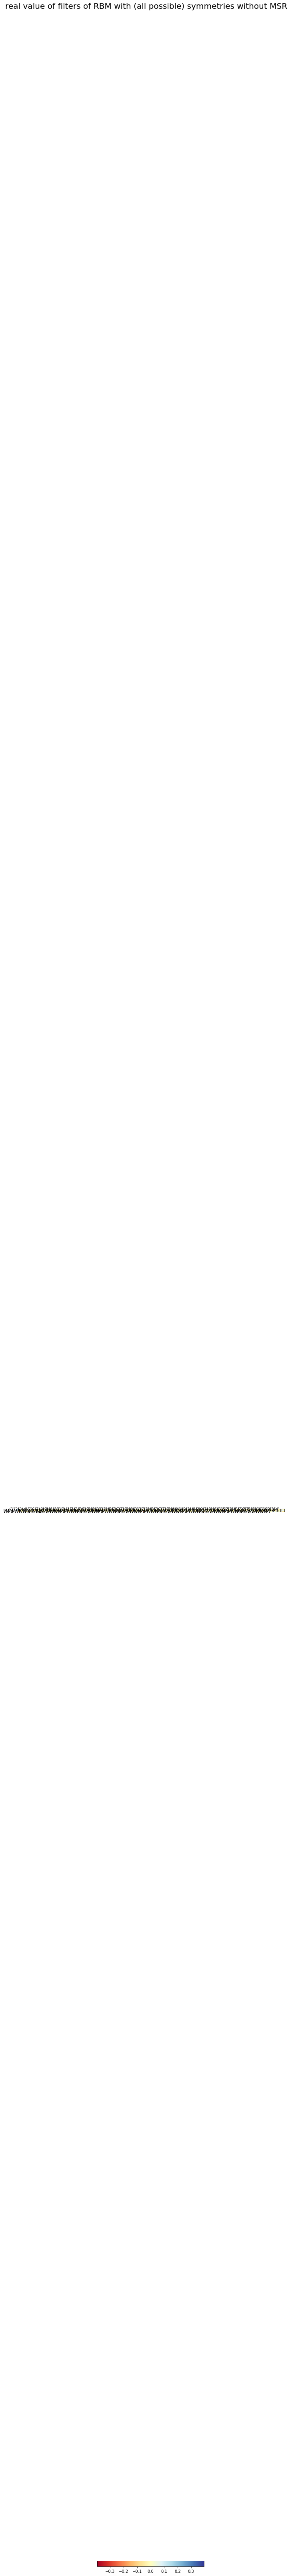

In [ ]:
L_NUM = 4
fig, axs = plt.subplots(1, no_of_filters, figsize=(12,2*no_of_filters))
#fig.tight_layout(pad=.0)
fig.subplots_adjust(top=1.9,bottom=0,wspace=.4)
fig.suptitle("real value of filters of RBM with (all possible) symmetries without MSR", fontsize=20)
for a in range(no_of_filters):
    im = axs[a].imshow(np.real(Filters[a]).reshape(L_NUM,L_NUM), cmap="RdYlBu", vmin=-extreme,vmax=extreme)#,interpolation="spline16")
    axs[a].set_ylabel(r"$W^{("+str(a+1)+r")}$", rotation=None,fontsize="x-large",horizontalalignment="right",verticalalignment="center")
    axs[a].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Now adding the colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=.4)

plt.show()